In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns

# Discrete Data + Probability

**Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.**

In [2]:
#acquire data
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)


In [3]:
df_orig.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df_orig.shape

(13974, 7)

In [5]:
new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   timestamp       13978 non-null  object
 2   request_method  13978 non-null  object
 3   status          13978 non-null  int64 
 4   size            13978 non-null  int64 
 5   destination     25 non-null     object
 6   request_agent   13978 non-null  object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [7]:
df.describe()

,status,size
count,13978.000000,1.397800e+04
mean,200.356703,4.500019e+05
std,10.182001,1.614915e+05
min,200.000000,0.000000e+00
25%,200.000000,5.006370e+05
50%,200.000000,5.101380e+05
75%,200.000000,5.112910e+05
max,499.000000,2.056327e+06


In [8]:
#clean up the timestamp by removing the brackets and trailing zeros
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

In [9]:
# replace the first colon in the timestamp before year 
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))

# set datetime index and sort
df = df.set_index('timestamp').sort_index()

In [10]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [11]:
# check destination values because there are nan
df.destination.value_counts()

"https://python.zach.lol/"                                        4
"https://ds.codeup.com/8.3_Acquire/"                              3
"https://python.zach.lol/api/v1/stores?page=1"                    2
"https://python.zach.lol/api/v1/"                                 2
"https://python.zach.lol/api/v1/stores?page=0"                    1
"https://python.zach.lol/api/v1/stores?page=2"                    1
"https://python.zach.lol/api/v1/sales?page=3"                     1
"https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!"                1
"https://python.zach.lol/api/v1/items"                            1
"https://python.zach.lol/api/v1/helloclass!"                      1
"https://python.zach.lol/api/v1//api/v1/items/next_page"          1
"https://python.zach.lol/api/V1/HiZach!"                          1
"http://localhost:8889/notebooks/timeseries_acquisition.ipynb"    1
"https://python.zach.lol/api/v1//api/v1/items"                    1
"https://python.zach.lol/api/v1//api/v1/items?pa

In [12]:
# clean some columns
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [13]:
#remove \?page=[0-9]+
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

In [14]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [15]:
#create a new column that size is in  megabytes (as new column)
df['size_mb'] = df['size'] / 1024/1024

In [16]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [17]:
# drop the size column
df.drop(columns= 'size', inplace = True)

In [18]:
df.head()

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488246


In [19]:
df.describe()

,status,size_mb
count,13978.000000,13978.000000
mean,200.356703,0.429155
std,10.182001,0.154010
min,200.000000,0.000000
25%,200.000000,0.477445
50%,200.000000,0.486506
75%,200.000000,0.487605
max,499.000000,1.961066


##  Detecting Anomalies in Discrete Variables

**Finding anomalies in already existing data:**
 - How many time a value of variable (e.g. request_method) shows up
 - Calculate probability for each request_method

In [20]:
df.head()

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488246


In [21]:
# how many unique request_method we have in the dataset?
df.request_method.value_counts(dropna=False)

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1items HTTP/1.1                           2
GET /api/v1/items/HTTP/1.1                          1
GET /api/v1 HTTP/1.1                                1
GET /api/v1//api/v1/items/next_page HTTP/1.1        1
GET /api/V1/HiZach! HTTP/1.1

In [22]:
#create a df that has the  counts of reques_method
rm_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
    rename(columns = {'index': 'request_method', 'request_method': 'req_method_cnt'} )

In [23]:
rm_df.head()

,request_method,req_method_cnt
0,GET /api/v1/sales HTTP/1.1,12403
1,GET /api/v1/items HTTP/1.1,1065
2,GET /api/v1/stores HTTP/1.1,229
3,GET / HTTP/1.1,107
4,GET /documentation HTTP/1.1,100


**calculate probabity for each request_method**

In [24]:
# rm_prob = req_method_cnt / total count in the df
rm_df.req_method_cnt / df.request_method.count()

0     0.887323
1     0.076191
2     0.016383
3     0.007655
4     0.007154
5     0.001860
6     0.000787
7     0.000501
8     0.000358
9     0.000286
10    0.000215
11    0.000215
12    0.000215
13    0.000215
14    0.000143
15    0.000072
16    0.000072
17    0.000072
18    0.000072
19    0.000072
20    0.000072
21    0.000072
Name: req_method_cnt, dtype: float64

In [25]:
#create a new column 
rm_df['rm_proba'] = rm_df.req_method_cnt / df.request_method.count()

In [26]:
rm_df.head()

,request_method,req_method_cnt,rm_proba
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154


In [27]:
# look at rows where ip_proba is less than 0.01
rm_df[rm_df.rm_proba < 0.01]

,request_method,req_method_cnt,rm_proba
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/sales/HTTP/1.1,3,0.000215
11,GET /api/v1/store HTTP/1.1,3,0.000215
12,GET /api/v1/sales/ HTTP/1.1,3,0.000215


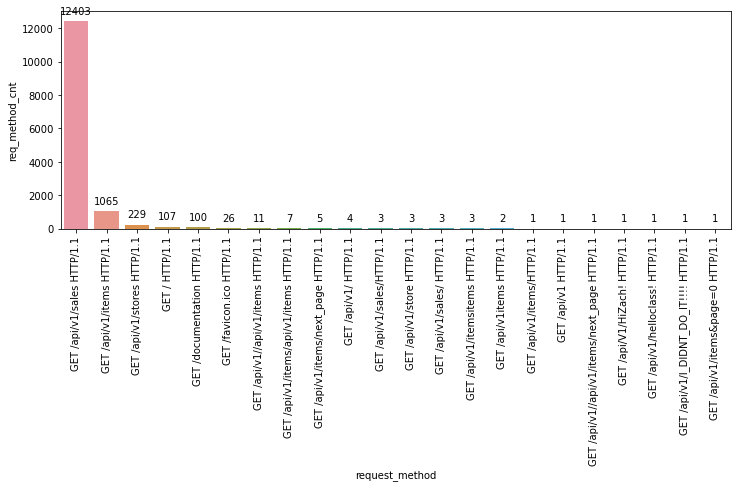

In [28]:
# plot the req_method_count for each request_method

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=rm_df, x = 'request_method', y = 'req_method_cnt', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

## Detecting anomalies by establishing a baseline and evaluate as new data arrives

**- Establish Baseline:**

In [29]:
df.head(1)


,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488753


In [30]:
df.tail(1)

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,NaN,python-requests/2.21.0,1.099591


In [31]:
# we want the original df
sample_df = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [32]:
sample_df.head()

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488246


In [33]:
sample_df.shape

(13974, 6)

In [34]:
sample_df.size /df.size

0.9997138360280441

In [35]:
#calculate the probabilities

In [36]:
sample_df.request_method.value_counts(dropna=False)

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1items HTTP/1.1                           2
GET /api/V1/HiZach! HTTP/1.1                        1
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1              1
GET /api/v1//api/v1/items/next_page HTTP/1.1        1
GET /api/v1/helloclass! HTTP/1.1                    1
GET /api/v1/items&page=0 HTT

In [37]:
sample_df.request_method.count()

13974

In [38]:
# Compute probabilities based on train sample:
rm_df = pd.DataFrame(sample_df.request_method.value_counts(dropna=False) / sample_df.request_method.count()).reset_index().\
    rename(columns = {'index': 'request_method', 'request_method': 'rm_proba'})

In [39]:
rm_df.head()

,request_method,rm_proba
0,GET /api/v1/sales HTTP/1.1,0.887577
1,GET /api/v1/items HTTP/1.1,0.076213
2,GET /api/v1/stores HTTP/1.1,0.016388
3,GET / HTTP/1.1,0.007657
4,GET /documentation HTTP/1.1,0.007156


### Merge probabilities with all data (sample+ new data):

In [40]:
rm_df.shape

(20, 2)

In [41]:
df.shape

(13978, 6)

In [42]:
# Where the request_method  is new, i.e. not seen in the sample 
#  dataset, fill the probability with a value of 0.
df = df.reset_index().merge(rm_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')


In [43]:
df[df.rm_proba == 0]

,ip,request_method,status,destination,request_agent,size_mb,rm_proba
timestamp,,,,,,,
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.000958,0.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.002441,0.0
2019-04-19 19:42:41,97.105.19.58,GET /api/v1/sales/HTTP/1.1,200,0,python-requests/2.21.0,1.961066,0.0
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,0,python-requests/2.21.0,1.099591,0.0


In [44]:
df.head()

,ip,request_method,status,destination,request_agent,size_mb,rm_proba
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488753,0.887577
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,0.076213
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486472,0.887577
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486377,0.887577
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488246,0.887577


### Conditional Probabilities: Probabilities using 2 discrete variables

**- Probability of Status given request_method**

In [45]:
sample_df.head()

,ip,request_method,status,destination,request_agent,size_mb
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,NaN,python-requests/2.21.0,0.488246


In [46]:
#Conditional probability. Probability of A given B

#  prob(A|B) = prob(A & B) / prob(B)

In [47]:
#size counts the number of nans too
sample_df.groupby('request_method').size()

request_method
GET / HTTP/1.1                                    107
GET /api/V1/HiZach! HTTP/1.1                        1
GET /api/v1 HTTP/1.1                                1
GET /api/v1/ HTTP/1.1                               4
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1//api/v1/items/next_page HTTP/1.1        1
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1              1
GET /api/v1/helloclass! HTTP/1.1                    1
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/items&page=0 HTTP/1.1                   1
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/stores HTTP/1.1                       229
GET /api/v1items HTTP/1.1                           2
GET /document

In [48]:
#calculate prob(a&b)

In [49]:
sample_df.groupby(['request_method', 'status']).size()

request_method                                status
GET / HTTP/1.1                                200         107
GET /api/V1/HiZach! HTTP/1.1                  200           1
GET /api/v1 HTTP/1.1                          200           1
GET /api/v1/ HTTP/1.1                         200           4
GET /api/v1//api/v1/items HTTP/1.1            200          11
GET /api/v1//api/v1/items/next_page HTTP/1.1  200           1
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1        200           1
GET /api/v1/helloclass! HTTP/1.1              200           1
GET /api/v1/items HTTP/1.1                    200        1061
                                              499           4
GET /api/v1/items&page=0 HTTP/1.1             200           1
GET /api/v1/items/api/v1/items HTTP/1.1       200           7
GET /api/v1/items/next_page HTTP/1.1          200           5
GET /api/v1/itemsitems HTTP/1.1               200           3
GET /api/v1/sales HTTP/1.1                    200       12391
                 

In [50]:
#using .div is the same as using /
#  prob(A|B) = prob(A & B) / prob(B)
Pab = sample_df.groupby(['request_method', 'status']).size().div(len(sample_df))

In [51]:
Pab

request_method                                status
GET / HTTP/1.1                                200       0.007657
GET /api/V1/HiZach! HTTP/1.1                  200       0.000072
GET /api/v1 HTTP/1.1                          200       0.000072
GET /api/v1/ HTTP/1.1                         200       0.000286
GET /api/v1//api/v1/items HTTP/1.1            200       0.000787
GET /api/v1//api/v1/items/next_page HTTP/1.1  200       0.000072
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1        200       0.000072
GET /api/v1/helloclass! HTTP/1.1              200       0.000072
GET /api/v1/items HTTP/1.1                    200       0.075927
                                              499       0.000286
GET /api/v1/items&page=0 HTTP/1.1             200       0.000072
GET /api/v1/items/api/v1/items HTTP/1.1       200       0.000501
GET /api/v1/items/next_page HTTP/1.1          200       0.000358
GET /api/v1/itemsitems HTTP/1.1               200       0.000215
GET /api/v1/sales HTTP/1.1           

In [52]:
sample_df.groupby(['request_method', 'status']).size()/(len(sample_df))

request_method                                status
GET / HTTP/1.1                                200       0.007657
GET /api/V1/HiZach! HTTP/1.1                  200       0.000072
GET /api/v1 HTTP/1.1                          200       0.000072
GET /api/v1/ HTTP/1.1                         200       0.000286
GET /api/v1//api/v1/items HTTP/1.1            200       0.000787
GET /api/v1//api/v1/items/next_page HTTP/1.1  200       0.000072
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1        200       0.000072
GET /api/v1/helloclass! HTTP/1.1              200       0.000072
GET /api/v1/items HTTP/1.1                    200       0.075927
                                              499       0.000286
GET /api/v1/items&page=0 HTTP/1.1             200       0.000072
GET /api/v1/items/api/v1/items HTTP/1.1       200       0.000501
GET /api/v1/items/next_page HTTP/1.1          200       0.000358
GET /api/v1/itemsitems HTTP/1.1               200       0.000215
GET /api/v1/sales HTTP/1.1           

In [53]:
#calculate Pb
Pb = sample_df.groupby('request_method').size().div(len(sample_df))

In [54]:
Pb

request_method
GET / HTTP/1.1                                  0.007657
GET /api/V1/HiZach! HTTP/1.1                    0.000072
GET /api/v1 HTTP/1.1                            0.000072
GET /api/v1/ HTTP/1.1                           0.000286
GET /api/v1//api/v1/items HTTP/1.1              0.000787
GET /api/v1//api/v1/items/next_page HTTP/1.1    0.000072
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1          0.000072
GET /api/v1/helloclass! HTTP/1.1                0.000072
GET /api/v1/items HTTP/1.1                      0.076213
GET /api/v1/items&page=0 HTTP/1.1               0.000072
GET /api/v1/items/api/v1/items HTTP/1.1         0.000501
GET /api/v1/items/next_page HTTP/1.1            0.000358
GET /api/v1/itemsitems HTTP/1.1                 0.000215
GET /api/v1/sales HTTP/1.1                      0.887577
GET /api/v1/sales/ HTTP/1.1                     0.000215
GET /api/v1/store HTTP/1.1                      0.000215
GET /api/v1/stores HTTP/1.1                     0.016388
GET /api/v1items

In [55]:
#prob(A|B) = prob(A & B) / prob(B)
Pab.div(Pb, axis = 0, level = 'request_method' )

request_method                                status
GET / HTTP/1.1                                200       1.000000
GET /api/V1/HiZach! HTTP/1.1                  200       1.000000
GET /api/v1 HTTP/1.1                          200       1.000000
GET /api/v1/ HTTP/1.1                         200       1.000000
GET /api/v1//api/v1/items HTTP/1.1            200       1.000000
GET /api/v1//api/v1/items/next_page HTTP/1.1  200       1.000000
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1        200       1.000000
GET /api/v1/helloclass! HTTP/1.1              200       1.000000
GET /api/v1/items HTTP/1.1                    200       0.996244
                                              499       0.003756
GET /api/v1/items&page=0 HTTP/1.1             200       1.000000
GET /api/v1/items/api/v1/items HTTP/1.1       200       1.000000
GET /api/v1/items/next_page HTTP/1.1          200       1.000000
GET /api/v1/itemsitems HTTP/1.1               200       1.000000
GET /api/v1/sales HTTP/1.1           

In [56]:
#other way
Pab/Pb

request_method                                status
GET / HTTP/1.1                                200       1.000000
GET /api/V1/HiZach! HTTP/1.1                  200       1.000000
GET /api/v1 HTTP/1.1                          200       1.000000
GET /api/v1/ HTTP/1.1                         200       1.000000
GET /api/v1//api/v1/items HTTP/1.1            200       1.000000
GET /api/v1//api/v1/items/next_page HTTP/1.1  200       1.000000
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1        200       1.000000
GET /api/v1/helloclass! HTTP/1.1              200       1.000000
GET /api/v1/items HTTP/1.1                    200       0.996244
                                              499       0.003756
GET /api/v1/items&page=0 HTTP/1.1             200       1.000000
GET /api/v1/items/api/v1/items HTTP/1.1       200       1.000000
GET /api/v1/items/next_page HTTP/1.1          200       1.000000
GET /api/v1/itemsitems HTTP/1.1               200       1.000000
GET /api/v1/sales HTTP/1.1           

In [57]:
# calculate prob for each request_method in sample_df

ip_probs = sample_df.groupby('request_method').size().div(len(sample_df))

ip_probs

request_method
GET / HTTP/1.1                                  0.007657
GET /api/V1/HiZach! HTTP/1.1                    0.000072
GET /api/v1 HTTP/1.1                            0.000072
GET /api/v1/ HTTP/1.1                           0.000286
GET /api/v1//api/v1/items HTTP/1.1              0.000787
GET /api/v1//api/v1/items/next_page HTTP/1.1    0.000072
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1          0.000072
GET /api/v1/helloclass! HTTP/1.1                0.000072
GET /api/v1/items HTTP/1.1                      0.076213
GET /api/v1/items&page=0 HTTP/1.1               0.000072
GET /api/v1/items/api/v1/items HTTP/1.1         0.000501
GET /api/v1/items/next_page HTTP/1.1            0.000358
GET /api/v1/itemsitems HTTP/1.1                 0.000215
GET /api/v1/sales HTTP/1.1                      0.887577
GET /api/v1/sales/ HTTP/1.1                     0.000215
GET /api/v1/store HTTP/1.1                      0.000215
GET /api/v1/stores HTTP/1.1                     0.016388
GET /api/v1items

In [58]:
# Conditional probability. Given a request_method, whbat is prob of a particular status

In [59]:
sample_df.groupby(['request_method', 'status']).\
                               size().div(len(sample_df))

request_method                                status
GET / HTTP/1.1                                200       0.007657
GET /api/V1/HiZach! HTTP/1.1                  200       0.000072
GET /api/v1 HTTP/1.1                          200       0.000072
GET /api/v1/ HTTP/1.1                         200       0.000286
GET /api/v1//api/v1/items HTTP/1.1            200       0.000787
GET /api/v1//api/v1/items/next_page HTTP/1.1  200       0.000072
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1        200       0.000072
GET /api/v1/helloclass! HTTP/1.1              200       0.000072
GET /api/v1/items HTTP/1.1                    200       0.075927
                                              499       0.000286
GET /api/v1/items&page=0 HTTP/1.1             200       0.000072
GET /api/v1/items/api/v1/items HTTP/1.1       200       0.000501
GET /api/v1/items/next_page HTTP/1.1          200       0.000358
GET /api/v1/itemsitems HTTP/1.1               200       0.000215
GET /api/v1/sales HTTP/1.1           

In [60]:
status_given_rm = pd.DataFrame(sample_df.groupby(['request_method', 'status']).\
                               size().div(len(sample_df)).\
                               div(ip_probs, 
                                   axis=0, 
                                   level='request_method').\
                               reset_index().\
                               rename(columns={0: 'proba_status_given_rm'})
                              )

In [61]:
status_given_rm

,request_method,status,proba_status_given_rm
0,GET / HTTP/1.1,200,1.000000
1,GET /api/V1/HiZach! HTTP/1.1,200,1.000000
2,GET /api/v1 HTTP/1.1,200,1.000000
3,GET /api/v1/ HTTP/1.1,200,1.000000
4,GET /api/v1//api/v1/items HTTP/1.1,200,1.000000
5,GET /api/v1//api/v1/items/next_page HTTP/1.1,200,1.000000
6,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,200,1.000000
7,GET /api/v1/helloclass! HTTP/1.1,200,1.000000
8,GET /api/v1/items HTTP/1.1,200,0.996244
9,GET /api/v1/items HTTP/1.1,499,0.003756


In [62]:
# calculate count for each combination of request_ and status

In [63]:
rm_status_count = pd.DataFrame(sample_df.groupby(['request_method', 'status'])['ip'].count().reset_index().\
            rename(columns={'ip':'rm_status_count'}))

In [64]:
rm_status_count

,request_method,status,rm_status_count
0,GET / HTTP/1.1,200,107
1,GET /api/V1/HiZach! HTTP/1.1,200,1
2,GET /api/v1 HTTP/1.1,200,1
3,GET /api/v1/ HTTP/1.1,200,4
4,GET /api/v1//api/v1/items HTTP/1.1,200,11
5,GET /api/v1//api/v1/items/next_page HTTP/1.1,200,1
6,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,200,1
7,GET /api/v1/helloclass! HTTP/1.1,200,1
8,GET /api/v1/items HTTP/1.1,200,1061
9,GET /api/v1/items HTTP/1.1,499,4


In [65]:
# merge ip_status_count with status_given_ip dataframe

rm_status =status_given_rm.merge(rm_status_count)

In [66]:
rm_status.head()

,request_method,status,proba_status_given_rm,rm_status_count
0,GET / HTTP/1.1,200,1.0,107
1,GET /api/V1/HiZach! HTTP/1.1,200,1.0,1
2,GET /api/v1 HTTP/1.1,200,1.0,1
3,GET /api/v1/ HTTP/1.1,200,1.0,4
4,GET /api/v1//api/v1/items HTTP/1.1,200,1.0,11


**Add these probabilities to original events to detect anomalous events:**

In [67]:
df = df.reset_index().merge(rm_status, on=['request_method', 'status'], how='left').fillna(value=0).set_index('timestamp')


In [68]:
df.head()

,ip,request_method,status,destination,request_agent,size_mb,rm_proba,proba_status_given_rm,rm_status_count
timestamp,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488753,0.887577,0.999032,12391.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,0,python-requests/2.21.0,0.003396,0.076213,0.996244,1061.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486472,0.887577,0.999032,12391.0
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.486377,0.887577,0.999032,12391.0
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,0,python-requests/2.21.0,0.488246,0.887577,0.999032,12391.0


In [69]:
df.shape

(13978, 9)

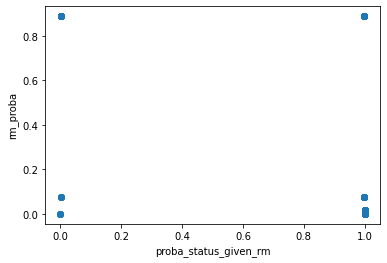

In [70]:
# plot the probabilities

plt.scatter(df.proba_status_given_rm, df.rm_proba)
plt.xlabel('proba_status_given_rm')
plt.ylabel('rm_proba');

In [71]:
df[(df['proba_status_given_rm'] < 0.2) & (df['rm_proba'] < 0.2)]

,ip,request_method,status,destination,request_agent,size_mb,rm_proba,proba_status_given_rm,rm_status_count
timestamp,,,,,,,,,
2019-04-16 20:38:13,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.076213,0.003756,4.0
2019-04-16 20:38:55,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.076213,0.003756,4.0
2019-04-16 20:39:00,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.076213,0.003756,4.0
2019-04-16 20:45:17,97.105.19.58,GET /api/v1/items HTTP/1.1,499,0,python-requests/2.21.0,0.000000,0.076213,0.003756,4.0
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.000958,0.000000,0.000000,0.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,0,python-requests/2.21.0,0.002441,0.000000,0.000000,0.0
2019-04-19 19:42:41,97.105.19.58,GET /api/v1/sales/HTTP/1.1,200,0,python-requests/2.21.0,1.961066,0.000000,0.000000,0.0
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,0,python-requests/2.21.0,1.099591,0.000000,0.000000,0.0


In [72]:
df.status.value_counts()

200    13960
499       16
301        2
Name: status, dtype: int64

https://www.exai.com/blog/http-status-codes-cheat-sheet

- 200 =  OK: Successful request.
- 301 = Moved Permanently: The server tells the client that the resource they look for has been moved permanently to another URL. All users and bots will be redirected to the new URL. It's a very important status code for SEO.
- 499 CLIENT CLOSED REQUEST

In [81]:
df [(df.ip == '97.105.19.58') & (df.request_method == 'GET /api/v1/items HTTP/1.1') ].groupby('status').count()

,ip,request_method,destination,request_agent,size_mb,rm_proba,proba_status_given_rm,rm_status_count
status,,,,,,,,
200,710,710,710,710,710,710,710,710
499,4,4,4,4,4,4,4,4


In [86]:
df [(df.ip == '97.105.19.58')].groupby('request_method').count().sort_values(by = 'ip', ascending = False)

,ip,status,destination,request_agent,size_mb,rm_proba,proba_status_given_rm,rm_status_count
request_method,,,,,,,,
GET /api/v1/sales HTTP/1.1,10885,10885,10885,10885,10885,10885,10885,10885
GET /api/v1/items HTTP/1.1,714,714,714,714,714,714,714,714
GET /api/v1/stores HTTP/1.1,159,159,159,159,159,159,159,159
GET / HTTP/1.1,95,95,95,95,95,95,95,95
GET /documentation HTTP/1.1,93,93,93,93,93,93,93,93
GET /favicon.ico HTTP/1.1,14,14,14,14,14,14,14,14
GET /api/v1//api/v1/items HTTP/1.1,11,11,11,11,11,11,11,11
GET /api/v1/items/next_page HTTP/1.1,5,5,5,5,5,5,5,5
GET /api/v1/items/api/v1/items HTTP/1.1,5,5,5,5,5,5,5,5


In [91]:
df[df.request_method=='GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1']

,ip,request_method,status,destination,request_agent,size_mb,rm_proba,proba_status_given_rm,rm_status_count
timestamp,,,,,,,,,
2019-04-16 20:01:02,97.105.19.58,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,200,0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.000154,0.000072,1.0,1.0
